In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load customer and transaction data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [3]:
# Merge customer and transaction data
merged_df = pd.merge(customers_df, transactions_df, on='CustomerID', how='left')

In [4]:
# Feature engineering
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])
merged_df['CustomerTenure'] = (merged_df['TransactionDate'] - merged_df['SignupDate']).dt.days

In [5]:
# Aggregate transaction data
customer_agg = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'CustomerTenure': 'mean'
}).reset_index()

In [6]:
# Merge aggregated data back to customer data
final_df = pd.merge(customers_df, customer_agg, on='CustomerID', how='left')

In [7]:
# Create dummy variables for Region (if applicable)
final_df = pd.get_dummies(final_df, columns=['Region'], prefix='Region')

In [8]:
# Select relevant features for clustering
features = ['TotalValue', 'Quantity', 'CustomerTenure'] 

In [9]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_df[features])

In [10]:
import numpy as np

num_missing = np.isnan(X_scaled).sum() 
print(f"Number of missing values: {num_missing}")

Number of missing values: 1


In [11]:
from sklearn.impute import SimpleImputer
# Impute the single missing value with the mean 
imputer = SimpleImputer(strategy='mean')
X_scaled = imputer.fit_transform(X_scaled)

In [12]:
# Find optimal number of clusters using the Elbow method and Silhouette score
inertia = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

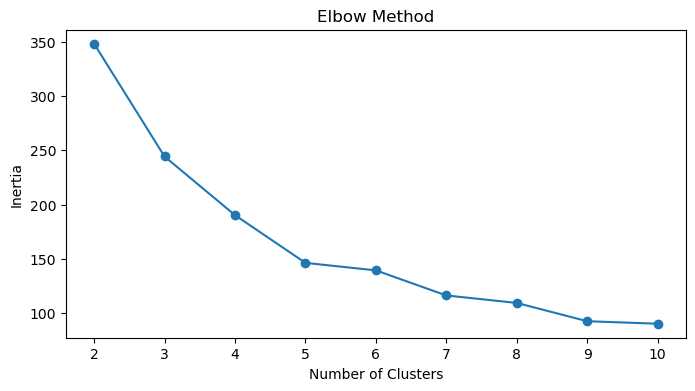

In [13]:
# Plot Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

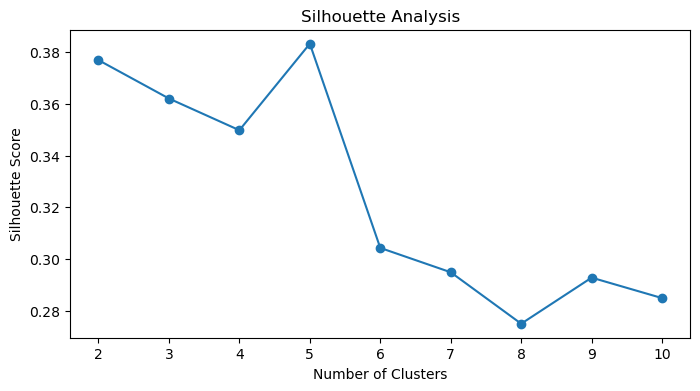

In [14]:
# Plot Silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

In [15]:
# Choose optimal number of clusters based on the plots (e.g., k=3)
optimal_k = 3

# Perform K-Means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

In [16]:
# Add cluster labels to the dataframe
final_df['Cluster'] = kmeans.labels_

# Calculate DB Index
db_index = davies_bouldin_score(X_scaled, kmeans.labels_)
print(f'DB Index: {db_index}')

DB Index: 0.9208535731773603


C:\Users\91886\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\91886\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\91886\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\91886\anaconda3\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

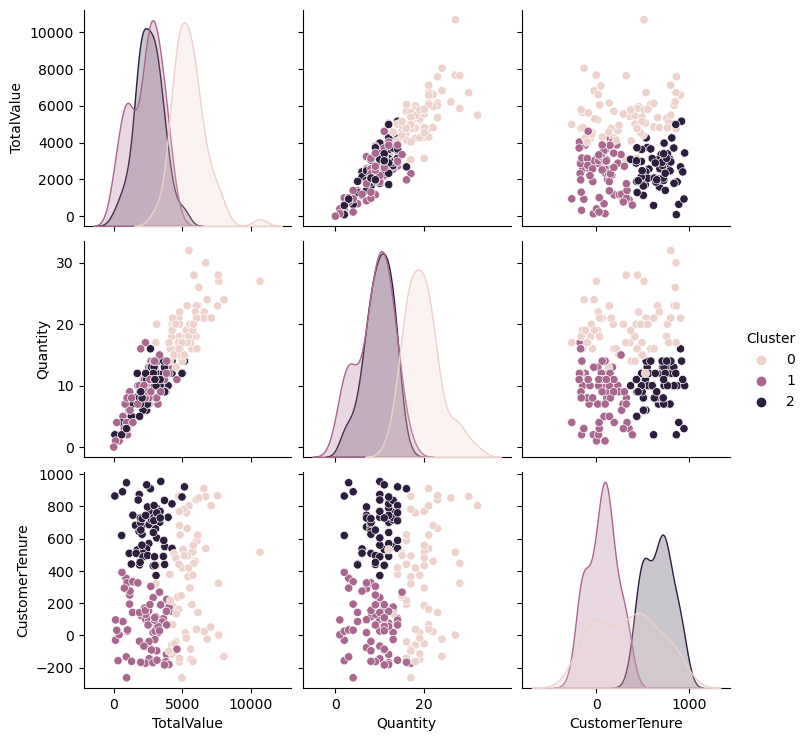

In [17]:
# Visualize clusters using pairplot
sns.pairplot(final_df, hue='Cluster', vars=features)
plt.show()

In [18]:
# Analyze cluster characteristics
cluster_summary = final_df.groupby('Cluster')[features].mean()
print(cluster_summary)

          TotalValue   Quantity  CustomerTenure
Cluster                                        
0        5505.706515  19.636364      331.159664
1        2323.888082   8.849315       66.678406
2        2573.362295   9.754098      667.394887
